# Preferential Sampling

We want to show that our model adjusts for preferential sampling, which leads to better estimates on a synthetic dataset.

In [12]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import pairwise_kernels

import matplotlib.pyplot as plt
import rasterio as rio
import geopandas as gpd
import warnings
from itertools import product
import pandas as pd

import torch
import torch.optim as optim
import torch.utils.data as utils

In [13]:
# Create synthetic data
x = np.linspace(0, 10, 50)
y = np.linspace(0, 10, 50)
X, Y = np.meshgrid(x, y)

grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Define true parameters for synthetic data generation
true_scaling = 2.0
true_intercept = 0.0

In [14]:
# define an RBF kernel function in numpy
def RBFkernel(x1, x2, l=1.0, sigma_f=1.0, sigma_n=1e-2, noise=False):
    # compute squared distance between points in x1 and x2
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    if noise == True: # If noise=True, add noise to cov matrix by incrementing diagonal elements by (sigma_n)^2, where x1 and x2 points are identical:
        sig_tmp=sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)
        for i,x1i in enumerate(x1):
            for j,x2j in enumerate(x2):
                if np.array_equal(x1i,x2j):
                    sig_tmp[i,j]+=sigma_n**2
        return sig_tmp
    else: # if noise=False, the covariance matrix is computed directly (without noise included)
        return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [15]:
kernel = RBF(length_scale=1.0)
covariance_matrix = pairwise_kernels(grid_points, metric='rbf', gamma=1.0/(2*1.0**2))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

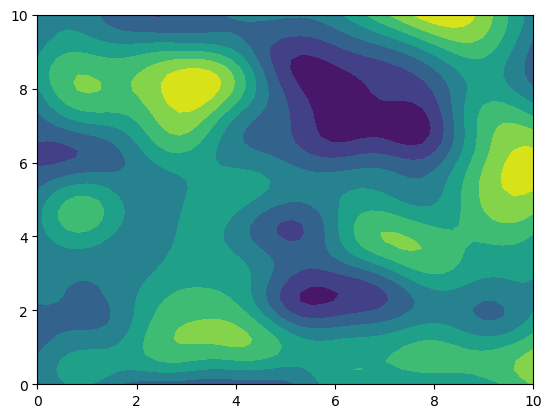

In [16]:
mean = np.zeros(grid_points.shape[0])
# Draw random samples from MVN:
np.random.seed(23)
process_values = np.random.multivariate_normal(mean, covariance_matrix)
# Create contour plot of process values

process_values_grid = process_values.reshape(X.shape)
plt.contourf(X, Y, process_values_grid)

In [17]:
def preferential_sampling(points, values, n_samples=50):
    # define the likelihood of sampling a location as a function of its value
    probabilities = softmax(true_scaling*values + true_intercept)
    # Points with higher probabilities (derived from higher values) are more likely to be sampled
    sampled_indices = np.random.choice(len(points), size=n_samples, p=probabilities, replace=False)
    return points[sampled_indices], values[sampled_indices], sampled_indices

# Sample points from the grid preferentially
sampled_points, sampled_values, sampled_indices = preferential_sampling(grid_points, process_values)

In [18]:
# Split data into training and testing:
n_samples = 50
all_indices = np.arange(len(grid_points))
unsampled_indices = np.setdiff1d(all_indices, sampled_indices) # finds set difference

# Training data (preferentially sampled)
X_train = sampled_points
y_train = sampled_values
# Testing data (unsampled)
X_test = grid_points[unsampled_indices]
y_test = process_values[unsampled_indices]

Because we have the ground truth, we want to make sure that our method can better predict at the unsampled locations (i.e., the MSE is lower on the held-out data compared with a basic GP).

### DeepKriging instead of Custom GP

In [19]:
from custom_dk_imports import DeepKrigingMLP, Trainer, NewLoss, MSELoss
import dill as pkl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader



In [20]:
# Assuming X_train and y_train are your spatial coordinates and target values, respectively
from custom_dk_imports import SpatialDataset


train_dataset = SpatialDataset(X_train, y_train)
val_dataset = SpatialDataset(X_test, y_test)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define simple DK model
num_hidden_layers = 3
hidden_dims = [64, 64, 64]
K = 1
batch_norm = True
p_dropout = 0.1
activation = "relu"
input_dim = 0  # input_dim: The dimension of the input tensor (features excluding spatial information)

deepkriging_model = DeepKrigingMLP(input_dim, num_hidden_layers, hidden_dims, K, batch_norm, p_dropout, activation)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deepkriging_model.to(device)

# Define the Trainer
optim_params = {'lr': 0.01}
trainer = Trainer(deepkriging_model, train_loader, val_loader, 'adam', optim_params, loss_fn=NewLoss(X_train, X_test, y_train), device=device, epochs=100, patience=10)

# Train the model
trainer.train()

/usr/local/Caskroom/miniforge/base/envs/torch-env/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Training started:

Early stopping - patience reached
Restoring the best model


In [21]:
# Fit and predict with basic GP (no preferential sampling adjustment)

from sklearn.gaussian_process import GaussianProcessRegressor
# Initialize and fit the basic GP model
basic_gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
basic_gp.fit(X_train, y_train)
y_pred_basic, y_std_basic = basic_gp.predict(X_test, return_std=True)

MSE (DeepKriging): 0.8062382479812252
MSE (Basic GP): 0.681191211327091


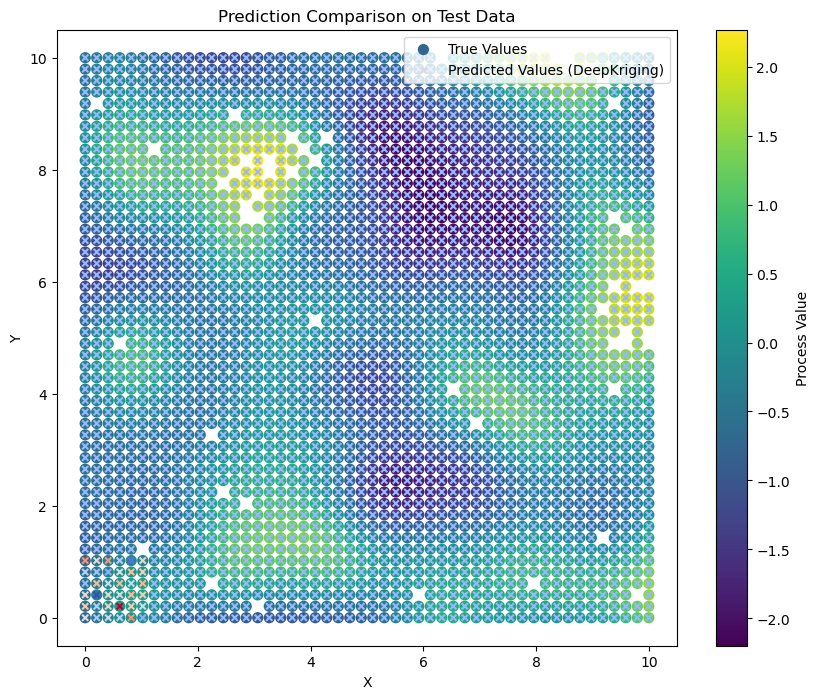

In [22]:
# Predict with the trained model
def predict_with_deepkriging(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            s_batch = batch[0].to(device)  # Spatial coordinates are in batch[0]
            preds = model(s=s_batch).cpu().numpy()  # Only pass s_batch since input_dim=0
            predictions.append(preds)
    return np.concatenate(predictions)

y_pred_deepkriging = predict_with_deepkriging(deepkriging_model, val_loader)

# Calculate MSE for DeepKriging model
mse_deepkriging = mean_squared_error(y_test, y_pred_deepkriging)
print(f'MSE (DeepKriging): {mse_deepkriging}')
mse_basic_gp = mean_squared_error(y_test, y_pred_basic)
print(f'MSE (Basic GP): {mse_basic_gp}')

# Visualization of results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', s=50, label='True Values')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_deepkriging, cmap='coolwarm', s=20, marker='x', label='Predicted Values (DeepKriging)')
plt.colorbar(scatter, label='Process Value')
plt.title("Prediction Comparison on Test Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()